# Project Description

## Problem Statement

The extracted clinical data contains snapshots of patients' health status at the point of admission into the ICU. This assignment aims to develop a strategy to select the right combination of features to build a predictor that estimates the patients' risk of acute organ failure in the Intensive Care Unit (ICU). The challenge involves implementing effective feature selection methods on the pre-extracted MIMIC data and developing multiple predictive models that can accurately assess the patients' chance of kidney failure, comparing their performances, and explaining why certain models perform better than others.

### Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'sph6004_assignment1_data.csv'
df = pd.read_csv(file_path)

In [3]:
# Count the distribution of AKI stages
aki_stage_counts = df['aki_stage'].value_counts()
print(aki_stage_counts)

aki_stage
0    16860
2    16288
1     9838
3     7934
Name: count, dtype: int64


50920


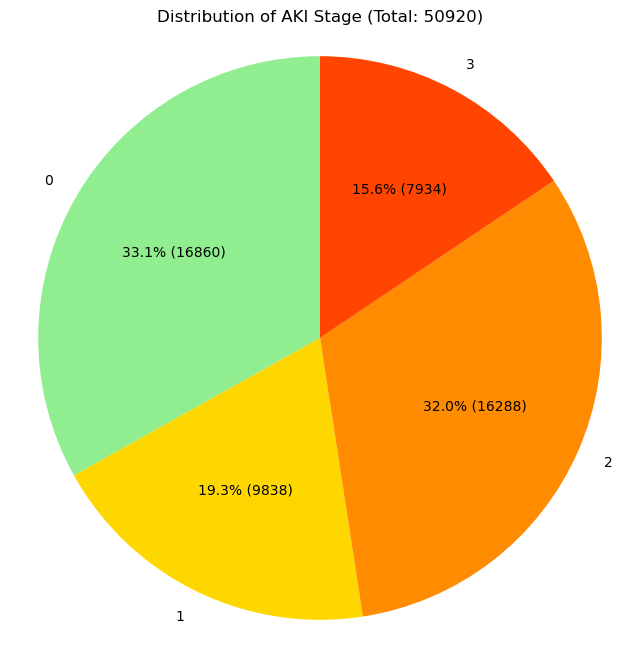

In [5]:
# 已统计出的 AKI Stage 计数
aki_stage_counts = {0: 16860, 1: 9838, 2: 16288, 3: 7934}

# Calculate total number of samples
total = sum(aki_stage_counts.values())
print(total)

# labels with percentage and count
autopct_labels = [f'{v / total * 100:.1f}% ({v})' for v in aki_stage_counts.values()]

# Define color palette
colors = ['#90EE90', '#FFD700', '#FF8C00', '#FF4500']

# Create pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    aki_stage_counts.values(),
    labels=aki_stage_counts.keys(),
    autopct=lambda p: autopct_labels.pop(0),  # Use pre-computed labels to avoid float precision issues
    colors=colors, 
    startangle=90,
)

plt.title(f'Distribution of AKI Stage (Total: {total})')
plt.axis('equal') 

plt.savefig('aki_stage_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Data Pre-processing

## One-hot encode the feature of gender and race

In [7]:
# race
# Identify unique race values
unique_races = df['race'].unique()
print("Unique race values:", unique_races)

# Count each race category
race_counts = df['race'].value_counts()
print("\nRace value counts:\n", race_counts)

Unique race values: ['WHITE' 'BLACK/AFRICAN AMERICAN' 'OTHER' 'UNKNOWN' 'UNABLE TO OBTAIN'
 'WHITE - RUSSIAN' 'BLACK/CAPE VERDEAN' 'PORTUGUESE'
 'HISPANIC/LATINO - SALVADORAN' 'HISPANIC/LATINO - PUERTO RICAN'
 'ASIAN - SOUTH EAST ASIAN' 'WHITE - BRAZILIAN' 'HISPANIC OR LATINO'
 'WHITE - OTHER EUROPEAN' 'BLACK/AFRICAN' 'PATIENT DECLINED TO ANSWER'
 'ASIAN' 'BLACK/CARIBBEAN ISLAND' 'HISPANIC/LATINO - CUBAN'
 'HISPANIC/LATINO - DOMINICAN' 'ASIAN - KOREAN' 'ASIAN - CHINESE'
 'ASIAN - ASIAN INDIAN' 'WHITE - EASTERN EUROPEAN'
 'HISPANIC/LATINO - GUATEMALAN' 'HISPANIC/LATINO - HONDURAN'
 'HISPANIC/LATINO - COLUMBIAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'AMERICAN INDIAN/ALASKA NATIVE' 'HISPANIC/LATINO - CENTRAL AMERICAN'
 'HISPANIC/LATINO - MEXICAN' 'SOUTH AMERICAN' 'MULTIPLE RACE/ETHNICITY']

Race value counts:
 race
WHITE                                        32637
UNKNOWN                                       5579
BLACK/AFRICAN AMERICAN                        3845
OTHER           

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Define race grouping mapping
race_group_mapping = {
    'WHITE': ['WHITE', 'WHITE - RUSSIAN', 'WHITE - BRAZILIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN'],
    'BLACK': ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/AFRICAN', 'BLACK/CARIBBEAN ISLAND'],
    'HISPANIC/LATINO': ['HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC OR LATINO', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - MEXICAN'],
    'ASIAN': ['ASIAN - SOUTH EAST ASIAN', 'ASIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN'],
    'NATIVE': ['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'AMERICAN INDIAN/ALASKA NATIVE'],
    'OTHER': ['OTHER', 'SOUTH AMERICAN', 'MULTIPLE RACE/ETHNICITY', 'PORTUGUESE'],
    'UNKNOWN': ['UNKNOWN', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']
}

# Group race column, replacing with broader categories
df['race'] = df['race'].apply(lambda x: next((group for group, values in race_group_mapping.items() if x in values), 'UNKNOWN'))

# Initialize and apply one-hot encoding for race
race_encoder = OneHotEncoder(sparse_output=False, drop="if_binary")
race_encoded = race_encoder.fit_transform(df[['race']])

# Convert race encoding to DataFrame with lowercase column names
race_encoded_df = pd.DataFrame(race_encoded, columns=race_encoder.get_feature_names_out(['race']))
race_encoded_df.columns = race_encoded_df.columns.str.lower()

# Initialize and apply one-hot encoding for gender
gender_encoder = OneHotEncoder(sparse_output=False, drop="if_binary")
gender_encoded = gender_encoder.fit_transform(df[['gender']])

# Convert gender encoding to DataFrame with lowercase column names
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['gender']))
gender_encoded_df.columns = gender_encoded_df.columns.str.lower()

# Merge encoded features and drop original categorical columns
df = pd.concat([df.drop(['race', 'gender'], axis=1), race_encoded_df, gender_encoded_df], axis=1)
print(df)

             id  hospital_mortality  aki_stage  admission_age  heart_rate_min  \
0      39553978                   0          0      52.559969            91.0   
1      39765666                   0          0      76.486231            68.0   
2      37067082                   0          0      55.881486            78.0   
3      31205490                   0          0      46.275517            55.0   
4      37510196                   1          2      77.018296            38.0   
...         ...                 ...        ...            ...             ...   
50915  32336619                   0          0      43.884161            76.0   
50916  31070865                   0          0      82.773493            63.0   
50917  36075953                   0          0      48.022487            93.0   
50918  38978960                   1          2      58.694264            71.0   
50919  36195440                   0          2      57.837531            76.0   

       heart_rate_max  hear

## Drop features with a high number of missing values

In [11]:
# Remove irrelevant features
df = df.drop(columns='id')
df = df.drop(columns='hospital_mortality')

# Calculate missing value ratio for each feature
missing_ratio = df.isnull().mean()

# Set threshold: features with missing values > 5% will be dropped
threshold = 0.05

# Identify features to drop and keep
features_to_drop = missing_ratio[missing_ratio > threshold].index
features_to_keep = missing_ratio[missing_ratio <= threshold].index

# Print deleted features
print("Deleted features:")
count = 0
for feature in features_to_drop:
    print(feature)
    count += 1
print("Number of deleted features:", count)

# Print features that will be kept
print("\nKept features:")
count = 0
for feature in features_to_keep:
    print(feature)
    count += 1
print("Number of remaining features:", count)
    
# Remove features with high missing value ratio
df = df.drop(columns=features_to_drop)

Deleted features:
lactate_min
lactate_max
ph_min
ph_max
so2_min
so2_max
po2_min
po2_max
pco2_min
pco2_max
aado2_min
aado2_max
aado2_calc_min
aado2_calc_max
pao2fio2ratio_min
pao2fio2ratio_max
baseexcess_min
baseexcess_max
bicarbonate_bg_min
bicarbonate_bg_max
totalco2_min
totalco2_max
hematocrit_bg_min
hematocrit_bg_max
hemoglobin_bg_min
hemoglobin_bg_max
carboxyhemoglobin_min
carboxyhemoglobin_max
methemoglobin_min
methemoglobin_max
temperature_bg_min
temperature_bg_max
chloride_bg_min
chloride_bg_max
calcium_bg_min
calcium_bg_max
glucose_bg_min
glucose_bg_max
potassium_bg_min
potassium_bg_max
sodium_bg_min
sodium_bg_max
albumin_min
albumin_max
globulin_min
globulin_max
total_protein_min
total_protein_max
calcium_lab_min
calcium_lab_max
abs_basophils_min
abs_basophils_max
abs_eosinophils_min
abs_eosinophils_max
abs_lymphocytes_min
abs_lymphocytes_max
abs_monocytes_min
abs_monocytes_max
abs_neutrophils_min
abs_neutrophils_max
atyps_min
atyps_max
bands_min
bands_max
imm_granulocytes_min

## Drop data points with missing values

In [13]:
# Count rows with missing values
missing_rows = df.isnull().any(axis=1).sum()

# Calculate total number of rows
total_rows = len(df)

# Calculate percentage of rows with missing values
missing_percentage = (missing_rows / total_rows) * 100

# Drop rows with any missing values
df = df.dropna()

# Print statistical information about missing data
print(f"Total rows: {total_rows}")
print(f"Rows with missing values: {missing_rows}")
print(f"Percentage of rows with missing values: {missing_percentage:.2f}%")

Total rows: 50920
Rows with missing values: 4927
Percentage of rows with missing values: 9.68%


## Drop outliers from the dataset

In [15]:
# Define a function to remove outliers
def remove_outliers(df, columns):
    for col in columns:
        # Calculate mean and standard deviation for the column
        mean = df[col].mean()
        std_dev = df[col].std()
        
        # Define bounds for outlier detection (3 standard deviations from the mean)
        lower_bound = mean - 3 * std_dev
        upper_bound = mean + 3 * std_dev
        
        # Filter out rows with values outside the defined bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [17]:
# Select columns for outlier removal
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Remove outliers from numeric columns
df_cleaned = remove_outliers(df, numeric_columns)

# Print the number of rows before and after cleaning
print(f"Original dataset rows: {len(df)}")
print(f"Cleaned dataset rows: {len(df_cleaned)}")

Original dataset rows: 45993
Cleaned dataset rows: 19550


## Feature normalization

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Select features to normalize (excluding aki_stage)
columns_to_normalize = [col for col in df.columns if col not in ['aki_stage']]

# Initialize MinMaxScaler
scaler = MinMaxScaler() 

# Apply normalization to selected features
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print(df.head())

   aki_stage  admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0          0       0.407214        0.555556        0.282787         0.464987   
1          0       0.689154        0.413580        0.180328         0.308644   
2          0       0.446354        0.475309        0.286885         0.442421   
3          0       0.333160        0.333333        0.225410         0.348603   
4          2       0.695423        0.228395        0.180328         0.293303   

    sbp_min   sbp_max  sbp_mean   dbp_min   dbp_max  ...  gcs_unable  \
0  0.445327  0.087108  0.214194  0.384615  0.122137  ...         0.0   
1  0.706349  0.306620  0.572385  0.653846  0.381679  ...         0.0   
2  0.635656  0.282230  0.524667  0.634615  0.366412  ...         0.0   
3  0.396385  0.156794  0.273453  0.423077  0.213740  ...         0.0   
4  0.505144  0.383275  0.447154  0.105769  0.366412  ...         1.0   

   weight_admit  race_asian  race_black  race_hispanic/latino  race_native  \
0      0

In [21]:
# 保存为 CSV 文件
df.to_csv('preprocessed_data.csv', index=False)
print(df.head())

   aki_stage  admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0          0       0.407214        0.555556        0.282787         0.464987   
1          0       0.689154        0.413580        0.180328         0.308644   
2          0       0.446354        0.475309        0.286885         0.442421   
3          0       0.333160        0.333333        0.225410         0.348603   
4          2       0.695423        0.228395        0.180328         0.293303   

    sbp_min   sbp_max  sbp_mean   dbp_min   dbp_max  ...  gcs_unable  \
0  0.445327  0.087108  0.214194  0.384615  0.122137  ...         0.0   
1  0.706349  0.306620  0.572385  0.653846  0.381679  ...         0.0   
2  0.635656  0.282230  0.524667  0.634615  0.366412  ...         0.0   
3  0.396385  0.156794  0.273453  0.423077  0.213740  ...         0.0   
4  0.505144  0.383275  0.447154  0.105769  0.366412  ...         1.0   

   weight_admit  race_asian  race_black  race_hispanic/latino  race_native  \
0      0

# Feature Selection

In [23]:
df = pd.read_csv('preprocessed_data.csv')

## A two-stage hierarchical approach

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Convert aki_stage to binary classification, 1 represents kidney failure.
df['binary_aki_stage'] = (df['aki_stage'] > 0).astype(int)

# Prepare features and target variable
X = df.drop(columns=['aki_stage', 'binary_aki_stage'])
y_binary = df['binary_aki_stage']

# Split data into training and testing sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

# Use L1 regularized logistic regression for feature selection
logistic_l1 = LogisticRegression(
    penalty='l1', 
    solver='liblinear', 
    C=0.1, 
    random_state=42
)
# Train the model
logistic_l1.fit(X_train_binary, y_train_binary)

# Identify features with non-zero coefficients
selected_features = X.columns[logistic_l1.coef_[0] != 0]
print("Selected features for binary classification:")
print(selected_features.tolist())

# Evaluate binary classification model
y_pred_binary = logistic_l1.predict(X_test_binary)
print("Binary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

Selected features for binary classification:
['admission_age', 'heart_rate_min', 'heart_rate_max', 'sbp_min', 'sbp_max', 'dbp_min', 'dbp_mean', 'mbp_min', 'mbp_max', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_vital_max', 'spo2_min', 'spo2_max', 'hematocrit_lab_max', 'hemoglobin_lab_min', 'platelets_min', 'bicarbonate_lab_min', 'bicarbonate_lab_max', 'bun_min', 'chloride_lab_max', 'creatinine_min', 'creatinine_max', 'glucose_lab_min', 'potassium_lab_max', 'gcs_min', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs_unable', 'weight_admit', 'race_asian', 'race_black', 'race_hispanic/latino', 'race_white', 'gender_m']
Binary Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.31      0.42      3006
           1       0.73      0.92      0.82      6193

    accuracy                           0.72      9199
   macro avg       0.70      0.62      0.62      9199
weighted avg       0.71      0.72      0.69      9199



# Building a Predictive Model

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Prepare multiclass dataset (preserving all classes: 0, 1, 2, 3)
X_multiclass = df[selected_features] 
y_multiclass = df['aki_stage']

# Split the dataset
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multiclass, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

## Logistic Regression

In [29]:
# Logistic Regression
# Train model using Logistic Regression
logistic_multiclass = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
logistic_multiclass.fit(X_train_multi, y_train_multi)


# Evaluate multiclass model
y_pred_multi = logistic_multiclass.predict(X_test_multi)
y_pred_proba_multi = logistic_multiclass.predict_proba(X_test_multi)

# Calculate multiclass metrics
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

# Output results
print("Multiclass Logistic Regression Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Multiclass Logistic Regression Performance:
AUROC: 0.6783
Precision: 0.4459
Recall: 0.4612
F1-Score: 0.4091


In [31]:
# Decision Tree
# # Train decision tree model
dt_multiclass = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt_multiclass.fit(X_train_multi, y_train_multi)

# Evaluate multiclass model
y_pred_multi = dt_multiclass.predict(X_test_multi)
y_pred_proba_multi = dt_multiclass.predict_proba(X_test_multi)

# Calculate multiclass performance metrics
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

print("Decision Tree Multiclass Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Decision Tree Multiclass Performance:
AUROC: 0.6476
Precision: 0.4103
Recall: 0.4417
F1-Score: 0.4114


In [33]:
# Random Forest
# Train Random Forest model
rf_multiclass = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1 
)
rf_multiclass.fit(X_train_multi, y_train_multi)

# Evaluate model
y_pred_multi = rf_multiclass.predict(X_test_multi)
y_pred_proba_multi = rf_multiclass.predict_proba(X_test_multi)

# Calculate multiclass performance metrics
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

print("Random Forest Multiclass Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Random Forest Multiclass Performance:
AUROC: 0.7016
Precision: 0.4737
Recall: 0.4832
F1-Score: 0.4298


In [35]:
# Support Vector Machine (SVM)
# Train SVM model
svm_multiclass = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)
svm_multiclass.fit(X_train_multi, y_train_multi)

# Evaluate model
y_pred_multi = svm_multiclass.predict(X_test_multi)
y_pred_proba_multi = svm_multiclass.predict_proba(X_test_multi)

# Calculate multiclass performance metrics
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

print("Support Vector Machine (SVM) Multiclass Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Support Vector Machine (SVM) Multiclass Performance:
AUROC: 0.6800
Precision: 0.4868
Recall: 0.4644
F1-Score: 0.4079


In [37]:
# Gradient Boost
# Train Gradient Boost model
gb_multiclass = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_multiclass.fit(X_train_multi, y_train_multi)

# Evaluate model
y_pred_multi = gb_multiclass.predict(X_test_multi)
y_pred_proba_multi = gb_multiclass.predict_proba(X_test_multi)

# Calculate multiclass performance metrics
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

print("Gradient Boosting Multiclass Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Gradient Boosting Multiclass Performance:
AUROC: 0.7096
Precision: 0.4613
Recall: 0.4891
F1-Score: 0.4395


In [39]:
# Adaptive Boosting (AdaBoost)
# Train AdaBoost model
estimator = DecisionTreeClassifier(max_depth=2)  # Weak classifier: shallow decision tree

adaboost_multiclass = AdaBoostClassifier(
    estimator=estimator, 
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
adaboost_multiclass.fit(X_train_multi, y_train_multi)

# Evaluate model
y_pred_multi = adaboost_multiclass.predict(X_test_multi)
y_pred_proba_multi = adaboost_multiclass.predict_proba(X_test_multi)

# Predict probabilities for AUROC calculation
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
auroc = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')

print("Adaptive Boosting (AdaBoost) Multiclass Performance:")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Adaptive Boosting (AdaBoost) Multiclass Performance:
AUROC: 0.6944
Precision: 0.4595
Recall: 0.4856
F1-Score: 0.4370
